
Percentage Returns for S&P 500:
S&P 500 Percentage Return: 138.3044413195916 %
XGBoost Model Accuracy: 0.694300518134715

Performance Metrics for XGBoost:
Sharpe Ratio (XGBoost): 1.7776251357647301
Sortino Ratio (XGBoost): 1.9155503304824382
Max Drawdown (XGBoost): 0.536347838237375

Percentage Returns for BTC and the XGBoost Strategy:
BTC Percentage Return: 181.7790209598667 %
XGBoost Strategy Percentage Return: 63663.029066760566 %

Trading Strategy Performance Metrics:
Gross Profit: 121647974328.53026 %
Gross Loss: 53261232.15481451 %
---------------------------------------------------------------------------
NOTE: the cumulative profit was calculated assuming NO LOSSES during any time in the trading period, hence the exponentially large number that is in no way reflective of the actual realised profit, or even the gross profit. The same goes for the gross loss.
---------------------------------------------------------------------------
Net Profit: 63663.029066760566 %
Total Closed

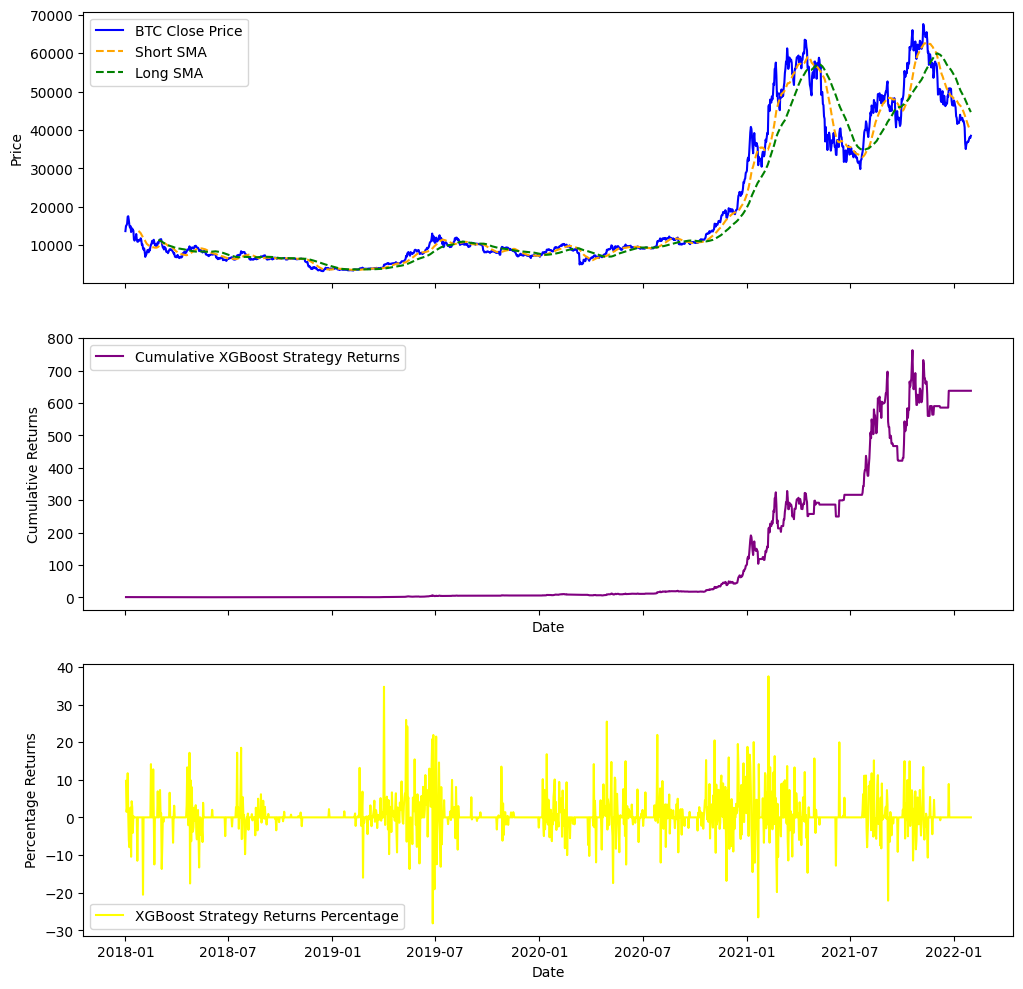

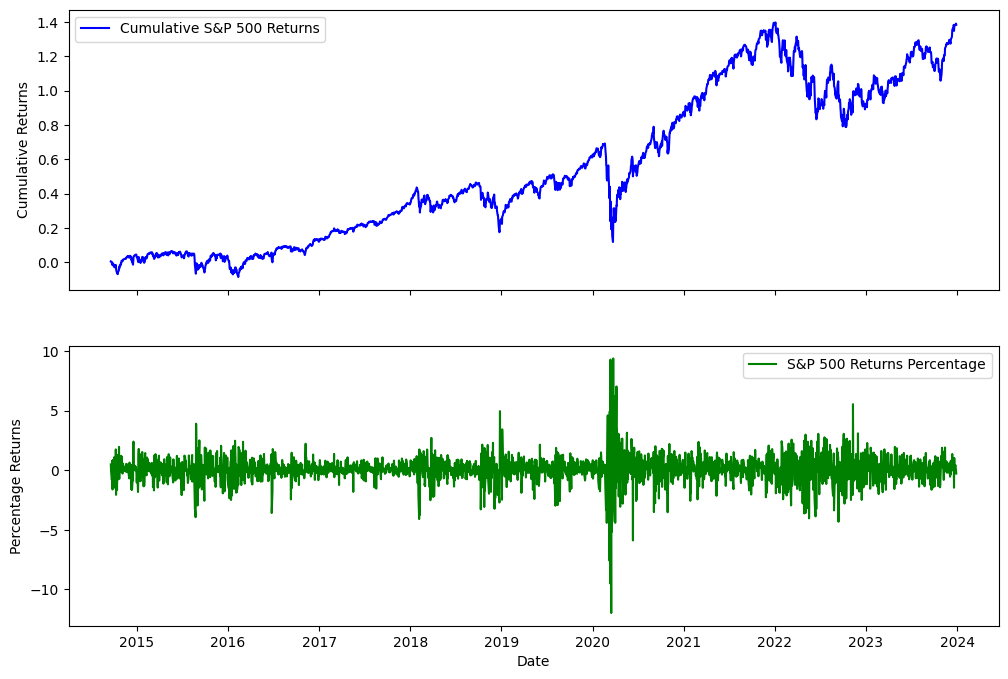

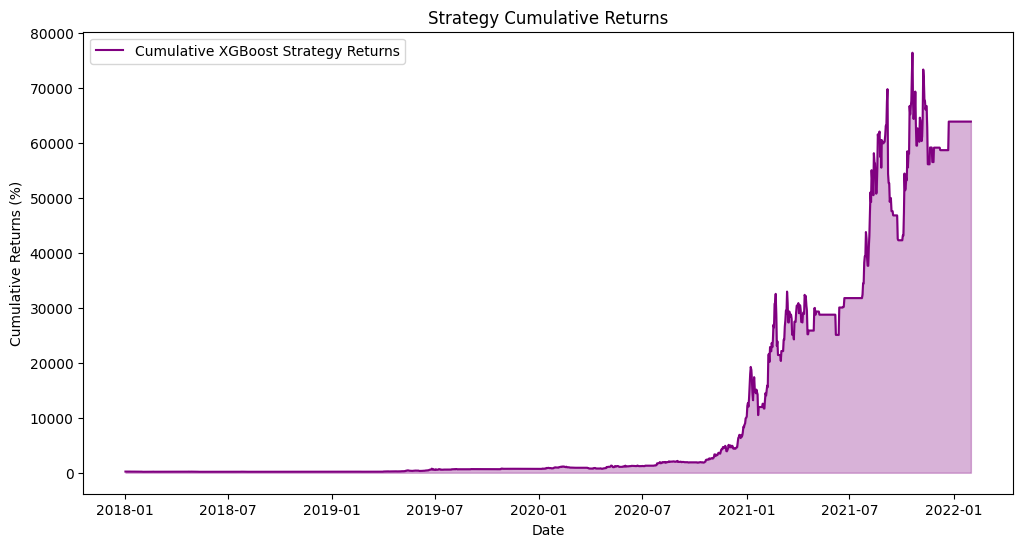

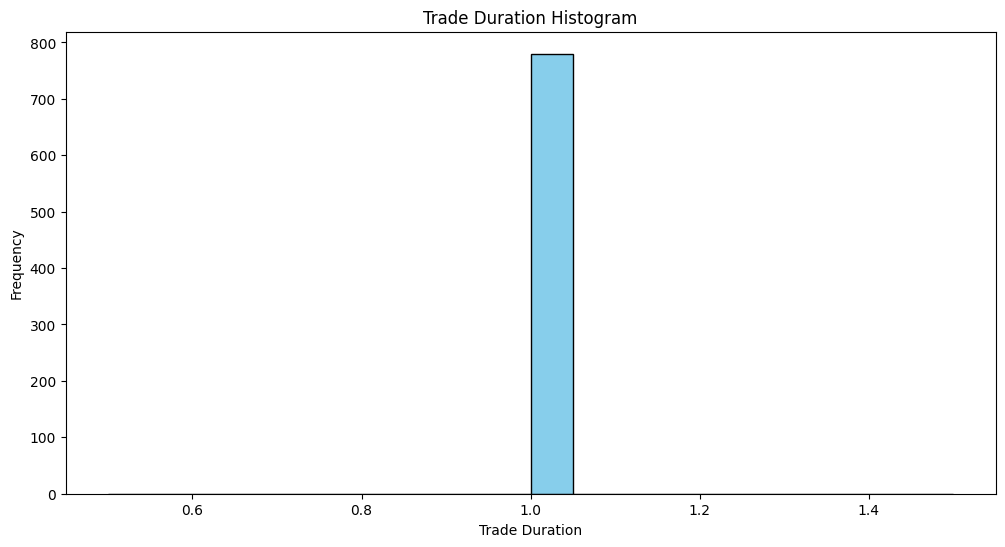

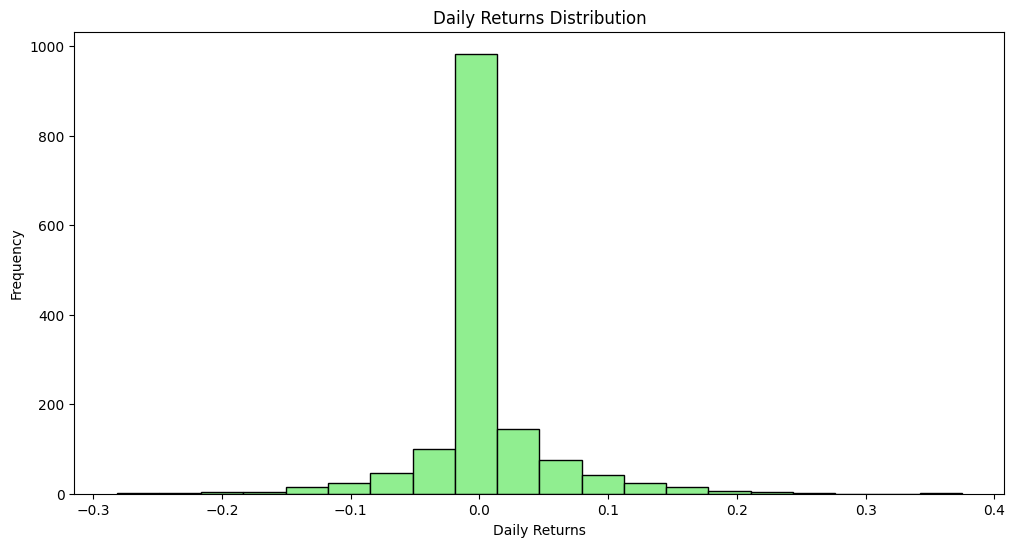

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import pandas_ta

# Load BTC data
# btc_file_path = r'C:\Users\rahul\Downloads\BTC-USD.csv'
# btc_data = pd.read_csv(btc_file_path)
btc_data = pd.read_csv('BTC-USD2.csv')
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)

# Load S&P 500 historical data
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate S&P 500 returns
sp500_data['sp500_returns_percentage'] = sp500_data['Adj Close'].pct_change() * 100

# Calculate cumulative S&P 500 returns
sp500_data['cumulative_sp500_returns'] = (1 + sp500_data['sp500_returns_percentage'] / 100).cumprod() - 1

# Calculate performance metrics for S&P 500
sp500_sharpe_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_sortino_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data[sp500_data['sp500_returns_percentage'] < 0]['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_max_drawdown = -(sp500_data['cumulative_sp500_returns'] / sp500_data['cumulative_sp500_returns'].cummax() - 1).min()

# Print performance metrics for S&P 500
# print("\nPerformance Metrics for S&P 500:")
# print("Sharpe Ratio (S&P 500):", sp500_sharpe_ratio)
# print("Sortino Ratio (S&P 500):", sp500_sortino_ratio)
# print("Max Drawdown (S&P 500):", sp500_max_drawdown)

# Print Percentage Returns for S&P 500
sp500_percentage_return = sp500_data['Adj Close'].iloc[-1] / sp500_data['Adj Close'].iloc[0] - 1
print("\nPercentage Returns for S&P 500:")
print("S&P 500 Percentage Return:", sp500_percentage_return*100,"%")

# Calculate additional indicators
btc_data['sma_short'] = btc_data['Close'].rolling(window=24).mean()
btc_data['sma_long'] = btc_data['Close'].rolling(window=59).mean()

btc_data['rsi'] = pandas_ta.rsi(close=btc_data['Close'],
                                length=14)
# Generate signals based on moving average crossover
btc_data['buy_signal'] = np.where(btc_data['sma_short'] > btc_data['sma_long'], 1, 0)
btc_data['sell_signal'] = np.where(btc_data['sma_short'] < btc_data['sma_long'], -1, 0)
btc_data['position'] = btc_data['buy_signal'] + btc_data['sell_signal']

# Convert target to [0, 1, 2]
target_classes = [-1, 0, 1]
btc_data['position'] = btc_data['position'].apply(lambda x: target_classes.index(x))

# Prepare features and target for machine learning model
features = btc_data[['rsi']]
target = btc_data['position']

# Impute NaN values in features
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Split data for machine learning model
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.12900000000000003, random_state=42)

# Tune XGBoost hyperparameters
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,  # Number of classes
    n_estimators=324,
    learning_rate=0.26,
    max_depth=6,
    subsample=0.32,
    gamma=1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy}")

# Implement strategy based on XGBoost predictions
btc_data['xgb_signal'] = xgb_model.predict(features_imputed)

# Backtest the XGBoost strategy
btc_data['returns'] = btc_data['Close'].pct_change()
btc_data['xgb_strategy_returns'] = btc_data['xgb_signal'].shift(1) * btc_data['returns']
btc_data['cumulative_xgb_strategy_returns'] = (1 + btc_data['xgb_strategy_returns']).cumprod()
btc_data['cumulative_gross_profit'] = (1 + btc_data['xgb_strategy_returns']).where(btc_data['xgb_strategy_returns'] > 0).cumprod().fillna(method='ffill')
btc_data['cumulative_gross_loss'] = (1 - btc_data['xgb_strategy_returns']).where(btc_data['xgb_strategy_returns'] < 0).cumprod().fillna(method='ffill')

# Calculate performance metrics for XGBoost
#sharpe ratio is an annual value. to account for the daily trades, we're multiplying by a scaling factor of sqrt(252)
xgb_sharpe_ratio = (btc_data['xgb_strategy_returns'].mean() / btc_data['xgb_strategy_returns'].std()) * np.sqrt(252) # 252 trading days in a year, on average
xgb_sortino_ratio = (btc_data['xgb_strategy_returns'].mean() / btc_data[btc_data['xgb_strategy_returns'] < 0]['xgb_strategy_returns'].std()) * np.sqrt(252)
xgb_max_drawdown = -(btc_data['cumulative_xgb_strategy_returns'] / btc_data['cumulative_xgb_strategy_returns'].cummax() - 1).min()

# Print performance metrics for XGBoost
print("\nPerformance Metrics for XGBoost:")
print("Sharpe Ratio (XGBoost):", xgb_sharpe_ratio)
print("Sortino Ratio (XGBoost):", xgb_sortino_ratio)
print("Max Drawdown (XGBoost):", xgb_max_drawdown)

# Print Percentage Returns for BTC and the XGBoost Strategy
btc_percentage_return = btc_data['Close'].iloc[-1] / btc_data['Close'].iloc[0] - 1
xgb_strategy_percentage_return = btc_data['cumulative_xgb_strategy_returns'].iloc[-1] - 1


print("\nPercentage Returns for BTC and the XGBoost Strategy:")
print("BTC Percentage Return:", btc_percentage_return*100,"%")
print("XGBoost Strategy Percentage Return:", xgb_strategy_percentage_return*100,"%")

# Calculate the requested metrics
# gross_profit = btc_data[btc_data['xgb_strategy_returns'] > 0]['xgb_strategy_returns'].sum()
# gross_loss = btc_data[btc_data['xgb_strategy_returns'] < 0]['xgb_strategy_returns'].sum()
gross_profit = btc_data[btc_data['cumulative_gross_profit']>0]['cumulative_gross_profit'].iloc[-1] - 1
gross_loss = btc_data[btc_data['cumulative_gross_loss']>0]['cumulative_gross_loss'].iloc[-1] - 1
net_profit = gross_profit - gross_loss
total_closed_trades = len(btc_data[btc_data['xgb_signal'] != 0])
win_rate = (len(btc_data[btc_data['xgb_strategy_returns'] > 0]) / total_closed_trades) * 100
max_drawdown = xgb_max_drawdown
average_winning_trade = gross_profit / len(btc_data[btc_data['xgb_strategy_returns'] > 0])
average_losing_trade = gross_loss / len(btc_data[btc_data['xgb_strategy_returns'] < 0])
buy_and_hold_return = btc_percentage_return * 100
largest_losing_trade = btc_data['xgb_strategy_returns'].min()
largest_winning_trade = btc_data['xgb_strategy_returns'].max()
sharpe_ratio = xgb_sharpe_ratio
sortino_ratio = xgb_sortino_ratio
btc_data['trade_duration'] = btc_data[btc_data['position'] != 0].groupby((btc_data['position'] != 0).cumsum()).cumcount() + 1
average_holding_duration_per_trade = btc_data[btc_data['position'] != 0]['trade_duration'].mean()
max_dip = btc_data['cumulative_xgb_strategy_returns'].max() - 1
average_dip = (btc_data['cumulative_xgb_strategy_returns'] - 1).mean()

# Print the calculated metrics
print("\nTrading Strategy Performance Metrics:")
print("Gross Profit:", gross_profit*100,"%")
print("Gross Loss:", gross_loss*100,"%")
print('---------------------------------------------------------------------------')
print("NOTE: the cumulative profit was calculated assuming NO LOSSES during any time in the trading period, hence the exponentially large number that is in no way reflective of the actual realised profit, or even the gross profit. The same goes for the gross loss.")
print('---------------------------------------------------------------------------')
print("Net Profit:", xgb_strategy_percentage_return*100,"%")
print("Total Closed Trades:", total_closed_trades)
print("Win Rate (Profitability %):", win_rate)
print("Max Drawdown:", max_drawdown)
print("Average Winning Trade (in USDT):", average_winning_trade)
print("Average Losing Trade (in USDT):", average_losing_trade)
print("Buy and Hold Return of BTC:", buy_and_hold_return)
print("Largest Losing Trade (in USDT):", largest_losing_trade)
print("Largest Winning Trade (in USDT):", largest_winning_trade)
print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)
print("Average Holding Duration per Trade:", average_holding_duration_per_trade)
print("Max Dip in Running Trade:", max_dip)
print("Average Dip in Running Trade:", average_dip)

# Plot Results for BTC
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot BTC Close Price and SMAs
ax1.plot(btc_data.index, btc_data['Close'], label='BTC Close Price', color='blue')
ax1.plot(btc_data.index, btc_data['sma_short'], label='Short SMA', color='orange', linestyle='--')
ax1.plot(btc_data.index, btc_data['sma_long'], label='Long SMA', color='green', linestyle='--')
ax1.set_ylabel('Price')
ax1.legend()

# Plot Cumulative XGBoost Strategy Returns
ax2.plot(btc_data.index, btc_data['cumulative_xgb_strategy_returns'], label='Cumulative XGBoost Strategy Returns', color='purple')
ax2.set_ylabel('Cumulative Returns')
ax2.set_xlabel('Date')
ax2.legend()

# Plot Percentage Returns for XGBoost Strategy (Now in yellow)
ax3.plot(btc_data.index, btc_data['xgb_strategy_returns'] * 100, label='XGBoost Strategy Returns Percentage', color='yellow')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percentage Returns')
ax3.legend()

plt.show()

# Plot Results for S&P 500
fig2, (ax4, ax5) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Cumulative Returns for S&P 500
ax4.plot(sp500_data.index, sp500_data['cumulative_sp500_returns'], label='Cumulative S&P 500 Returns', color='blue')
ax4.set_ylabel('Cumulative Returns')
ax4.legend()

# Plot Percentage Returns for S&P 500
ax5.plot(sp500_data.index, sp500_data['sp500_returns_percentage'], label='S&P 500 Returns Percentage', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Percentage Returns')
ax5.legend()

plt.show()

# Add the calculation of trade_duration
btc_data['trade_duration'] = btc_data[btc_data['position'] != 0].groupby((btc_data['position'] != 0).cumsum()).cumcount() + 1

# Plot Drawdown Chart
fig4, ax4 = plt.subplots(figsize=(12, 6))
ax4.plot(btc_data.index, (btc_data['cumulative_xgb_strategy_returns'] + 1) * 100, label='Cumulative XGBoost Strategy Returns', color='purple')
ax4.fill_between(btc_data.index, 0, (btc_data['cumulative_xgb_strategy_returns'] + 1) * 100, color='purple', alpha=0.3)
ax4.set_xlabel('Date')
ax4.set_ylabel('Cumulative Returns (%)')
ax4.set_title('Strategy Cumulative Returns')
ax4.legend()


# Plot Trade Duration Histogram
fig5, ax5 = plt.subplots(figsize=(12, 6))
ax5.hist(btc_data[btc_data['position'] != 0]['trade_duration'], bins=20, edgecolor='black', color='skyblue')
ax5.set_xlabel('Trade Duration')
ax5.set_ylabel('Frequency')
ax5.set_title('Trade Duration Histogram')


# Plot Daily Returns Distribution
fig6, ax6 = plt.subplots(figsize=(12, 6))
ax6.hist(btc_data['xgb_strategy_returns'].dropna(), bins=20, edgecolor='black', color='lightgreen')
ax6.set_xlabel('Daily Returns')
ax6.set_ylabel('Frequency')
ax6.set_title('Daily Returns Distribution')
plt.show()

#generating tech deliverables csv
btc_data['buy_signal'] = np.where(btc_data['sma_short'] > btc_data['sma_long'], 1, 0)
btc_data['sell_signal'] = np.where(btc_data['sma_short'] < btc_data['sma_long'], -1, 0)
btc_data['Signals'] = btc_data['buy_signal']+btc_data['sell_signal']
tech_deliverables = btc_data.drop(['Adj Close','Volume','sma_short','sma_long','xgb_strategy_returns','xgb_signal','buy_signal','sell_signal','cumulative_gross_profit','cumulative_gross_loss','trade_duration'],axis=1)
tech_deliverables = tech_deliverables[['Signals', 'Open', 'High', 'Low', 'Close','cumulative_xgb_strategy_returns']]
tech_deliverables
tech_deliverables.to_csv('backtest_logs.csv', index=False)

# TESTING TESTING TESTING 